# Readme
Tут два файла истории EURUSD 1 за 2016 год часовой тик. 2016й полньій год можна использовать для обучения, а часть 2017-го для валидации, я включил 2.5 месяца в 2017й.

Данньіе в файлах идут как Local time, Open,High, Low,Close, Volume

Не знаю насколько тьі знаком с такими данньіми. Коротко, то Open - цена в начале тика данньіх, Close - в конце периода, ну и High Low внутренние колебания наибольшая и наименьшая цена
В принципе все 4, и также Volume, обьем продаж за етот период, важньі. Но для простотьі можем пока что брать только Open цену для обучального набора примеров

Тут Gnuplot скрипт для примера чтобьі рисовать Candlesticks и етих данньіх

Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее
Таким образом learning set будет иметь 8754 примера

# Unanswered questions:
- How to analyze seasonal and residual parts? Separately or sum up again?
- (!) [Kallman filter](https://en.wikipedia.org/wiki/Kalman_filter#Applications), see in [.tsa](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html?highlight=kalmanfilter#statsmodels.tsa.statespace.kalman_filter.KalmanFilter) is better than moving average, exp smoothing or ARIMA, see [coursera](https://www.coursera.org/lecture/machine-learning-trading-finance/kalman-filter-trading-applications-jEt1T). How to construct and use it?
- If `seasonal_decompose` worked well and the remaining TS is stationary, then there is no need to use SARIMAX and ARIMA, ARMA is enough?
- Differenced series has almost no trend, but high seasonality and even higher residuals, which appear periodically!
- What does it mean? Should we use [ARCH/GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) models?
- How to find the `p,q` and `P,D,Q` numbers looking at AC and PC?

# Answered questions:
- Can we make predictions with `seasonal_decompose`? **No**, `seasonal_decompose` is a filter. One has to select a model for prediction.
- Is 732 our `S` - seasonal length? **yes**
- Why there is a spike in the AC and PC functions around 290 hours? **It is not 290, but 290x2, 732 after sorting by date.** 
    - is it one year? **yes**
    - how to take it into account, with freq=290? **yes**
    - how to find the precise number? **len(series) / number of observed periods**
- How to find the `d`, looking at AC and PC? **yes, and find the order of differencing with the smallest `.std()`**

# Contents:
## [Useful links](#Links)

## [Data Wrangling](#DWr)
- Import packages and read the data
- [Plot the data](#PlotData)
- [Plot with `plotly.io`](#plotly)

## [Standard ARIMA](#ARIMA) (In progress)
- SARIMAX [Terminology](#SARIMAX)
- Auto fits:
    - `statsmodels.tsa`
        - [seasonal_decompose](#seasonal_decompose)
        - [STL](#STL)
        - Fit [ARIMA](#ARIMAtsa)
        - Use [ARIMA after STL](#STL+ARIMA) seasonal decomposition
        - [SARIMAX](#SARIMAXtsa)
        - [TS decomposition and prediction](#TSdeco)
    - `pmdarima`
        - [auto_arima](#auto_arima) 
    - `theano`
        - fast [Bayesian estimation](#BSARIMAX) of SARIMAX models
- [Manual](#ARIMAman) fits.
    - Identify the [order of differencing](#Order)
    - Check [seasonality](#SARIMA)
    - Identify the number of [AR and MA](#ARMA) terms in the ARIMA model

## Combine [LSTM and ARIMA](#LSTM+ARIMA) (TODO)

===================================================================================================================

## Useful links<a id='Links'></a>
- [Chapter 9 **ARIMA models**](https://otexts.com/fpp3/arima.html) from the book "Forecasting: Principles and Practice (3rd ed)", *Rob J **Hyndman** and George Athanasopoulos*, Monash University, Australia
- [statsmodels.org](https://www.statsmodels.org/stable/index.html) python package that includes models for time series analysis.
- [**Time Series Forecasting — ARIMA, LSTM, Prophet with Python**](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887) from [Caner Dabakoglu](https://medium.com/@cdabakoglu) at https://medium.com/
- [The Secret Betting Strategy That Beats Online Bookmakers](https://www.technologyreview.com/2017/10/19/67760/the-secret-betting-strategy-that-beats-online-bookmakers/) from [MIT Technology Review](https://www.technologyreview.com/)
     - the source: "Beating the bookies with their own numbers - and how the online sports betting market is rigged", see [arxiv](https://arxiv.org/abs/1710.02824).
     
     
- [Autoregressive Integrated Moving Average (ARIMA)](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp) from www.investopedia.com. Good definitions.

- **[ARIMA Models lesson](https://classroom.udacity.com/courses/ud980/lessons/ff6cb612-1832-4254-8a87-b4defef8dd58/concepts/308e3827-a9dc-4437-8e0e-eb742662a89d) in the [Time Series Forecasting](https://classroom.udacity.com/courses/ud980) Course by Udacity.**
- **(!) [Partial Autocorrelation Function (PACF)](https://online.stat.psu.edu/stat510/lesson/2/2.2)** from Penn State Eberly College of Science **(short and with math!!!)**
- **(!) [ARIMA models for time series forecasting](http://people.duke.edu/~rnau/411arim2.htm) from Duke University.**
- **(!) [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/#:~:text=A%20partial%20autocorrelation%20is%20a,relationships%20of%20intervening%20observations%20removed.) from machinelearningmastery.com**

## Data Wrangling<a id='DWr'></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read the input files
# Select short names in order to not retype the same stuff. 
df      = pd.read_table('EURUSD_1H_2016.txt',sep=',')
#df_long = pd.read_table('EURUSD_1H_2005_2016.txt',sep=',')

In [3]:
# Preview the dataframe
df

Local time     Open     High      Low    Close  Volume
0     01.01.2016 00:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
1     01.01.2016 01:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
2     01.01.2016 02:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
3     01.01.2016 03:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
4     01.01.2016 04:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
...                       ...      ...      ...      ...      ...     ...
8778  31.12.2016 19:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8779  31.12.2016 20:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8780  31.12.2016 21:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8781  31.12.2016 22:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8782  31.12.2016 23:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0

[8783 rows x 6 columns]

In [4]:
# Check for nan values 
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [5]:
# Check type
type(df)

pandas.core.frame.DataFrame

In [6]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null object
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [7]:
# Check info
#df_long.info()

### Plot the data<a id='PlotData'></a>

In [8]:
# Plot everything as a line
#df.plot.line();
# Plot in log scale
#df.plot.line(logy=True);

**`Volume` is much larger than anything else.**

In [9]:
# Plot only 'Open'
#df.Open.plot.line();

In [10]:
# Plot 'Open' and 'Close'
df.plot.line(y={'Open','Close'});

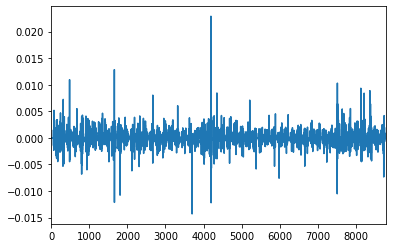

In [11]:
# Plot the difference of 'Open' and 'Close'
(df.Open - df.Close).plot.line();

**`Open` almost coincides with `Close`.**

In [12]:
# Plot 'High' and 'Low'
#df.plot.line(y={'High','Low'});

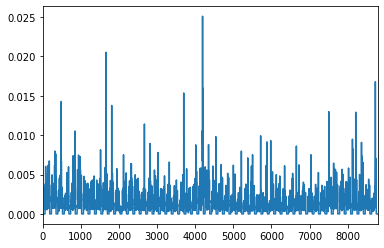

In [13]:
# Plot the difference of 'High' and 'Low'
(df.High - df.Low).plot.line();

### Plot with `plotly.io`<a id='plotly'></a>
see [this article](https://medium.com/analytics-vidhya/python-i-have-tested-a-trading-mathematical-technic-in-realtime-658a80381151) by [Sajid Lhessani](https://lhessani-sajid.medium.com/) from [medium.com](https://medium.com/), see also the corresponding [video](https://www.youtube.com/watch?v=95MZRSOccEg).

In [14]:
import plotly.io as pio
import plotly.graph_objs as go

pio.renderers.default='notebook'

**(!) One has to sort by index, in order to get a properly connected lines, [see this](https://community.plotly.com/t/scatterplot-lines-unwanted-connecting/8729/3).**

In [15]:
data = df.copy()
# Convert to datetime
data['Local time'] = pd.to_datetime(data['Local time'])
# Set time to index
data.set_index('Local time', inplace=True)
data = data.sort_index()
data

Open     High      Low    Close  Volume
Local time                                                     
2016-01-01 00:00:00  1.08564  1.08564  1.08564  1.08564     0.0
2016-01-01 01:00:00  1.08564  1.08564  1.08564  1.08564     0.0
2016-01-01 02:00:00  1.08564  1.08564  1.08564  1.08564     0.0
2016-01-01 03:00:00  1.08564  1.08564  1.08564  1.08564     0.0
2016-01-01 04:00:00  1.08564  1.08564  1.08564  1.08564     0.0
...                      ...      ...      ...      ...     ...
2016-12-31 19:00:00  1.05150  1.05150  1.05150  1.05150     0.0
2016-12-31 20:00:00  1.05150  1.05150  1.05150  1.05150     0.0
2016-12-31 21:00:00  1.05150  1.05150  1.05150  1.05150     0.0
2016-12-31 22:00:00  1.05150  1.05150  1.05150  1.05150     0.0
2016-12-31 23:00:00  1.05150  1.05150  1.05150  1.05150     0.0

[8783 rows x 5 columns]

In [16]:
# Add mean for Close ##Draw the middle band, higher band, lowest band
data['Middle Band'] = data['Close'].rolling(window=21).mean()
data['Upper Band'] = data['Middle Band'] + 1.96*data['Close'].rolling(window=21).std()
data['Lower Band'] = data['Middle Band'] - 1.96*data['Close'].rolling(window=21).std()
data

Open     High      Low    Close  Volume  Middle Band  \
Local time                                                                     
2016-01-01 00:00:00  1.08564  1.08564  1.08564  1.08564     0.0          NaN   
2016-01-01 01:00:00  1.08564  1.08564  1.08564  1.08564     0.0          NaN   
2016-01-01 02:00:00  1.08564  1.08564  1.08564  1.08564     0.0          NaN   
2016-01-01 03:00:00  1.08564  1.08564  1.08564  1.08564     0.0          NaN   
2016-01-01 04:00:00  1.08564  1.08564  1.08564  1.08564     0.0          NaN   
...                      ...      ...      ...      ...     ...          ...   
2016-12-31 19:00:00  1.05150  1.05150  1.05150  1.05150     0.0       1.0515   
2016-12-31 20:00:00  1.05150  1.05150  1.05150  1.05150     0.0       1.0515   
2016-12-31 21:00:00  1.05150  1.05150  1.05150  1.05150     0.0       1.0515   
2016-12-31 22:00:00  1.05150  1.05150  1.05150  1.05150     0.0       1.0515   
2016-12-31 23:00:00  1.05150  1.05150  1.05150  1.05150     0.0       1.0515   

                     Upper Band  Lower Band  
Local time                                   
2016-01-01 00:00:00         NaN         NaN  
2016-01-01 01:00:00         NaN         NaN  
2016-01-01 02:00:00         NaN         NaN  
2016-01-01 03:00:00         NaN         NaN  
2016-01-01 04:00:00         NaN         NaN  
...                         ...         ...  
2016-12-31 19:00:00      1.0515      1.0515  
2016-12-31 20:00:00      1.0515      1.0515  
2016-12-31 21:00:00      1.0515      1.0515  
2016-12-31 22:00:00      1.0515      1.0515  
2016-12-31 23:00:00      1.0515      1.0515  

[8783 rows x 8 columns]

In [17]:
#declare figure
#data = data['2016-02-01':'2016-02-28']
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y= data['Middle Band'],line=dict(color='blue', width=.7), name = 'Middle Band'))
fig.add_trace(go.Scatter(x=data.index, y= data['Upper Band'],line=dict(color='red', width=1.5), name = 'Upper Band (Sell)'))
fig.add_trace(go.Scatter(x=data.index, y= data['Lower Band'],line=dict(color='green', width=1.5), name = 'Lower Band (Buy)'))

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='EURUSD_1H_2016',
    yaxis_title='Exchange rate EUR/USD')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show('notebook')

# Make a standard ARIMA based model<a id='ARIMA'></a>

## **SARIMAX Terminology:**<a id='SARIMAX'></a>
We follow [Monthly Spot Price Prediction - Time Series Analysis by State Space Method.](https://towardsdatascience.com/monthly-spot-price-prediction-time-series-analysis-by-state-space-method-34aedf6ba294) from [towardsdatascience.com](https://towardsdatascience.com)
- SARIMAX is `S`easonal `A`uto`r`egressive `I`ntegrated `M`oving-`A`verage with e`X`ogenous regressors.
- Parameters: (p,d,q) (P,D,Q)S (X)
    - **p - non-seasonal autoregressive order**, the `AR` part
    - **d - order of differencing**, the `I` part
    - **q - non-seasonal moving average order**, the `MA` part
    - P - seasonal autoregressive order
    - D - order of seasonal differencing
    - Q - seasonal moving average order
    - S - seasonal length
    - X - vector of external variables
- The fitness of model is diagnosed using `Ljung-Box Q statistic` **(?)** to check the adequacy.
- We use the [SARIMAX model](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) implemented in [statsmodels.org](https://www.statsmodels.org/).

**(!) One can determine whether the final (differenced) series is stationary using [ADF/KPSS test](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html):**
1. Both tests conclude that the series is not stationary - The series is not stationary
2. Both tests conclude that the series is stationary - The series is stationary
3. KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
4. KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

**Select the data.**

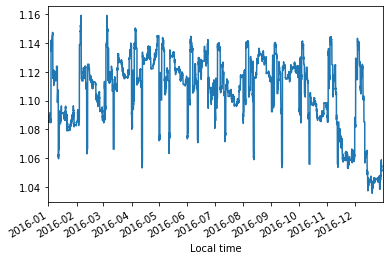

In [18]:
# Copy only "Close"
df_close = data.Close.copy()
# Make index datetime and indicate the frequency - hourly
# https://stackoverflow.com/questions/58510659/error-valuewarning-a-date-index-has-been-provided-but-it-has-no-associated-fr
#df_close.index = pd.DatetimeIndex(df_close.index).to_period('h')
#df_close = df_close.sort_index()
df_close.plot.line();

In [19]:
# Calculate the number of counts in one month.
freq = round(len(df_close)/12)
freq

732

## seasonal_decompose from `statmodels.tsa`<a id='seasonal_decompose'></a>
The [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose) is a Time Series Filters for Seasonal decomposition using moving averages, see [.tsa documentation](https://www.statsmodels.org/stable/tsa.html).

In [20]:
#!conda install -c conda-forge statsmodels==0.12.2 --y

In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 

In [22]:
freq

732

In [23]:
type(df_close)

pandas.core.series.Series

In [24]:
df_close.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Local time', length=8783, freq=None)

In [25]:
#df_close.head()

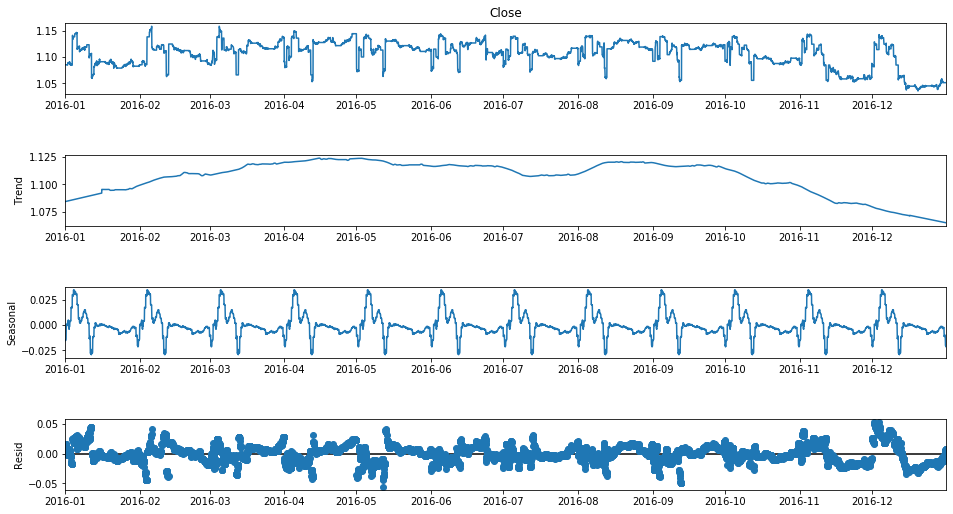

In [26]:
#data = df_close #df_close_diff_1
res = seasonal_decompose(df_close, period=freq, model='additive', two_sided=True, extrapolate_trend=freq)#, freq=freq, model='additive')
#res.trend.plot();
#plt.close() # Close previous plot
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [27]:
print('mean\t',res.resid.mean(),'\n',
      'var\t','',res.resid.var(),'\n',
      'max\t','',res.resid.max(),'\n',
      'min\t', res.resid.min())

mean	 -2.9102567956979218e-05 
 var	  0.0002107739572596876 
 max	  0.05417704825131344 
 min	 -0.05546664027424967


**(!) `Trend` is calculated using `moving average` for the middle of the region obtained by `+-freq` if `two_sided=True` (default) is selected. If False, the filter coefficients are for past values only.**

**(!) `two_sided=True` is better, because `mean` is then smaller, while it becomes less important whether we started counting on the rising or decaying trend.**

In [28]:
#res = seasonal_decompose(df_close, period=freq, model='multiplicative')
#fig = res.plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)
#plt.show()

- **(!) `additive` and `multiplicative` models give similar results, but `additive` seasonal and residual components vary around zero, while for `multiplicative` they vary around unity.**
- **(!) Residual is larger than seasonal.** 
- **What does it mean?**
- **(?) Should we use [ARCH/GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) models?**
- **(?) Can we make predictions with `seasonal_decompose`?**

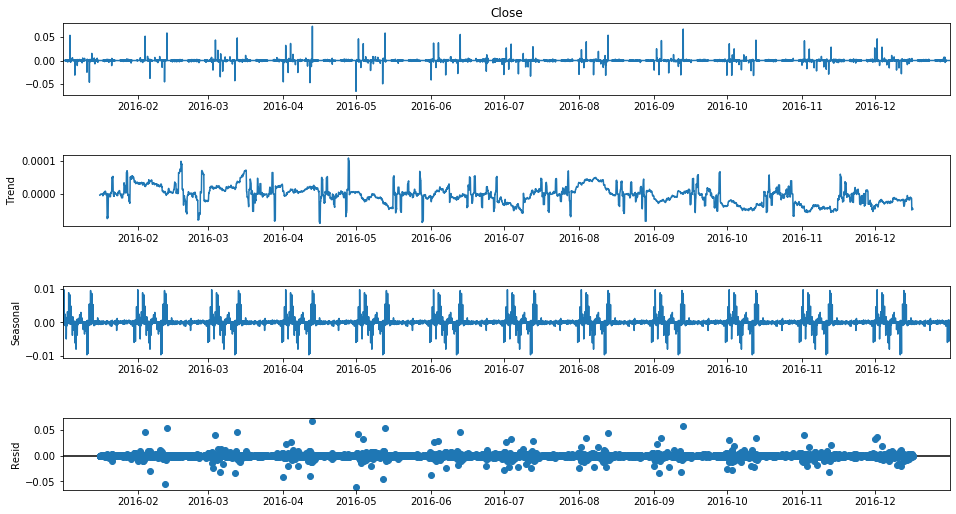

In [29]:
df_close_diff_1 = df_close.diff().dropna()
data = df_close_diff_1
res = seasonal_decompose(data, period=freq)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

- **(!) Differenced series has almost no trend, but high seasonality and even higher residuals, which appear periodically!**
- **What does it mean?**
- **Should we use [ARCH/GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) models?**

In [30]:
#732/2

In [31]:
#res.trend[365:]

## STL from `statmodels.tsa`<a id='STL'></a>
The [STL](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL) - Season-Trend decomposition using [LOESS](https://en.wikipedia.org/wiki/Local_regression) **L**ocally **E**stimated **S**catterplot **S**moothing, see [.tsa documentation](https://www.statsmodels.org/stable/tsa.html).

In [32]:
#!pip install statsmodels==0.12.1

In [33]:
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#data = co2.load(True).data
#data = data.resample('M').mean().ffill()

In [34]:
from statsmodels.tsa.seasonal import STL
#res = STL(data).fit()
#res.plot()
#plt.show()

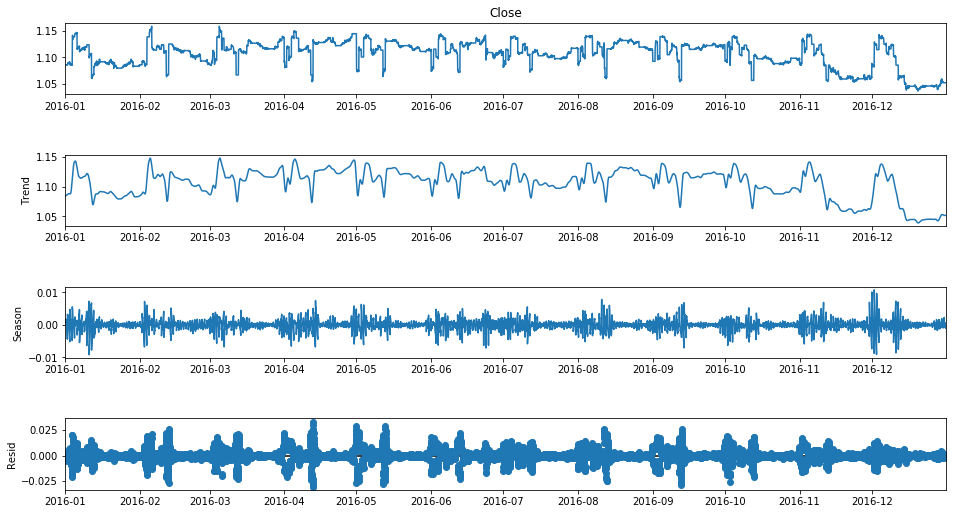

In [35]:
data = df_close
data = data.resample('H').mean().ffill()
res = STL(data).fit()
#res.plot()
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [36]:
print('mean\t',res.resid.mean(),'\n',
      'var\t','',res.resid.var(),'\n',
      'max\t','',res.resid.max(),'\n',
      'min\t', res.resid.min())

mean	 2.818744782276086e-07 
 var	  2.705609350492819e-05 
 max	  0.03332695434143451 
 min	 -0.030232902483374957


In [37]:
#res.resid+res.seasonal

**(!) `STL` makes a better decomposition, making residuals much smaller!**

**(?) How to analyze seasonal and residual parts? Separately? Add again?**

In [38]:
type(fig.plot())

AttributeError: 'Figure' object has no attribute 'plot'

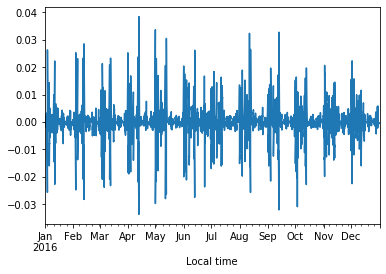

In [39]:
fig = (res.seasonal + res.resid).plot()
#fig.set_figheight(8)
#fig.set_figwidth(15)
#plt.show()

## Fit ARIMA with `statsmodels.tsa`<a id='ARIMAtsa'></a>
There are the [following ways](https://www.statsmodels.org/stable/tsa.html) to get the order of ARIMA in `statsmodels.tsa`:
- [stattools.arma_order_select_ic(y[, max_ar, …])](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html#statsmodels.tsa.stattools.arma_order_select_ic): Compute information criteria for many ARMA models.
- [statsmodels.tsa.x13.x13_arima_select_order](https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_select_order.html): Perform automatic seasonal ARIMA order identification using x12/x13 ARIMA. See [tips for the implementation](https://stackoverflow.com/questions/32053770/arima-seasonal-prediction-with-python-x12a-and-x13as-not-found-on-path).
- [ar_model.ar_select_order(endog, maxlag[, …])](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ar_select_order.html#statsmodels.tsa.ar_model.ar_select_order): Autoregressive AR-X(p) model order selection.
    - [arima_process.ar2arma(ar_des, p, q[, n, …])](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ar2arma.html#statsmodels.tsa.arima_process.ar2arma): Find arma approximation to ar process.

In [40]:
from statsmodels.tsa.arima.model import ARIMA

In [41]:
endog = df_close
#mod = sm.tsa.arima.ARIMA(endog, order=(1, 1, 1))
mod = ARIMA(endog, order=(1, 1, 1))
res = mod.fit()
print(res.summary())

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8783
Model:                 ARIMA(1, 1, 1)   Log Likelihood               36700.834
Date:                Thu, 01 Apr 2021   AIC                         -73395.668
Time:                        23:54:04   BIC                         -73374.427
Sample:                             0   HQIC                        -73388.431
                               - 8783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0304      0.010     -3.034      0.002      -0.050      -0.011
ma.L1          0.0291      0.010      2.905      0.004       0.009       0.049
sigma2      1.373e-05   2.51e-08    547.857      0.0

**(!) the `fit` method above fitted the parameters to match the initialy selected model `(1,1,1)`, but we need to select the type of the model first!**

## Use ARIMA after STL seasonal decomposition<a id='STL+ARIMA'></a>
Example from the [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html).

In [42]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.datasets import macrodata
ds = macrodata.load_pandas()
data = np.log(ds.data.m1)
base_date = f"{int(ds.data.year[0])}-{3*int(ds.data.quarter[0])+1}-1"
data.index = pd.date_range(base_date, periods=data.shape[0], freq="QS")

In [43]:
stlf = STLForecast(data, ARIMA, model_kwargs={"order": (1, 0, 1)})
res = stlf.fit()
forecasts = res.forecast(12)

In [44]:
forecasts

2010-01-01    7.453256
2010-04-01    7.434694
2010-07-01    7.432312
2010-10-01    7.423018
2011-01-01    7.449113
2011-04-01    7.430554
2011-07-01    7.428175
2011-10-01    7.418885
2012-01-01    7.444983
2012-04-01    7.426428
2012-07-01    7.424053
2012-10-01    7.414765
Freq: QS-JAN, dtype: float64

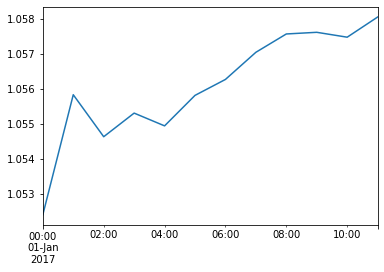

In [45]:
data = df_close
data = data.resample('H').mean().ffill()
res = STL(data).fit()
stlf = STLForecast(data, ARIMA, model_kwargs={"order": (1, 0, 1)})
res = stlf.fit()
forecasts = res.forecast(12)
forecasts.plot();
#res.plot()
#fig = res.plot()

**(!) STL is a filter. Forecasting is possible if a forecasting method, e.g. ARIMA, is selected.** 

## SARIMAX with `statsmodels.tsa`<a id='SARIMAXtsa'></a>

see [documentation](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html?highlight=sarimax)

## TS decomposition and prediction<a id='TSdeco'></a>
We follow [the template](https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/) by [S666](https://pythonforfinance.net/author/s666/) from [pythonforfinance.net](https://pythonforfinance.net/), see also [basic-data-analysis](https://pythonforfinance.net/category/basic-data-analysis/) there.

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

import matplotlib.pyplot as plt
import seaborn as sns

# include below line if you are using Jupyter Notebook
%matplotlib inline

# Set figure width to 12 and height to 9
plt.rcParams['figure.figsize'] = [15, 9]

#df = pd.read_csv('EURUSD.csv',sep='\t', index_col='Date')
#df = pd.read_table('EURUSD_1H_2016.txt',sep=',')
#df.index = pd.to_datetime(df.index)
#df.sort_index(inplace=True)
#df = df.resample('W').last()
#df = df.resample('H').mean().ffill()
#series = df['Price']
series = df_close                        # Just this line gives ValueError: Unable to determine period from endog after applying "STL(series).fit()" below
#series = series.resample('H')           # Gives TypeError: float() argument must be a string or a number, not 'Timestamp' after applying the "hpfilter" below.
#series = series.resample('H').ffill()   # Gives ValueError: cannot reindex a non-unique index with a method or limit
#series = series.resample('H').mean()    # Gives neither "Trend" nor "Cycle" after applying the "hpfilter" below.
#series = series.mean().ffill()          # Gives AttributeError: 'float' object has no attribute 'ffill'
series = series.resample('H').mean().ffill()  # It needs all of the methods to work properly.

**(?) What means `.resample('W').last()` and `.resample('H').mean().ffill()`?**\
**(!)** These are Pandas methods.
- [.resample()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) Resample time-series data. I adds `Freq: H` in the series description.
- [.mean()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) Return the mean of the values over the requested axis.
- [.ffill()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html) Returns Series/DataFrame or None. Object with missing values filled or None if inplace=True.

**(?) Why exactly do they work together as they do?**

In [20]:
series.head()

Local time
2016-01-01 00:00:00    1.08564
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
Freq: H, Name: Close, dtype: float64

In [21]:
df_close.head()

Local time
2016-01-01 00:00:00    1.08564
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
Name: Close, dtype: float64

**Apply [Hodrick-Prescott Filter](https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter)** to remove the cyclical component of a time series from raw data. It is used to obtain a smoothed-curve representation of a time series, one that is more sensitive to long-term than to short-term fluctuations. 
**Drawbacks:** The Hodrick–Prescott filter will only be optimal when:
- Data exists in a I(2) trend.
    - If one-time permanent shocks or split growth rates occur, the filter will generate shifts in the trend that do not actually exist.
- Noise in data is approximately normally distributed.
- Analysis is purely historical and static (closed domain). The filter causes **misleading predictions when used dynamically** since the algorithm changes (during iteration for minimization) the past state (unlike a moving average) of the time series to adjust for the current state regardless of the size of $\lambda$  used.

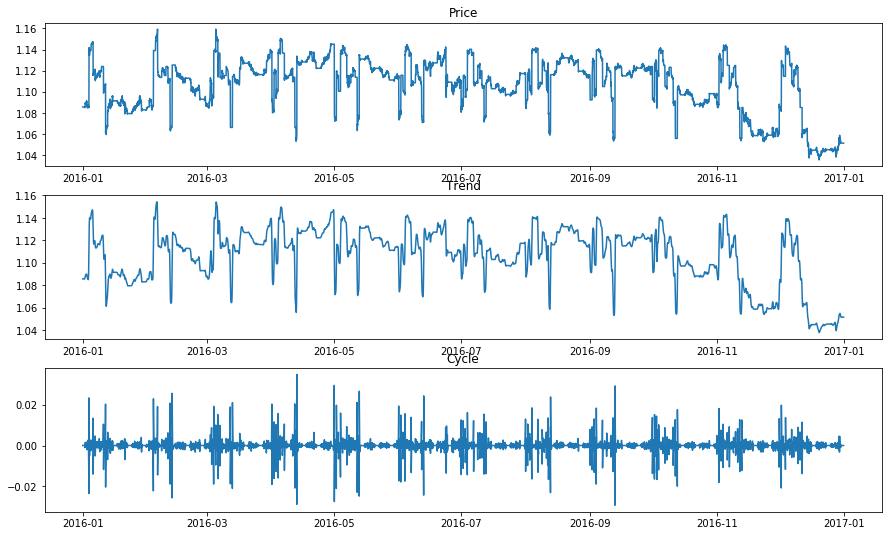

In [22]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)# 50)
#print('cycle,trend',cycle,trend)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

**Seasonal and Trend decomposition using Loess (STL)**

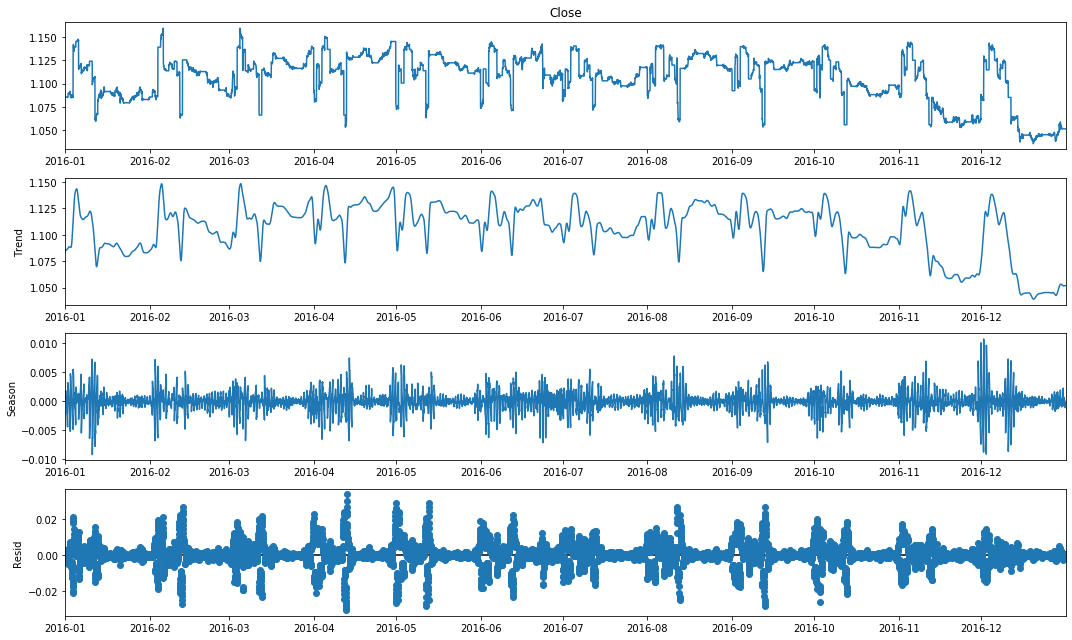

In [23]:
result = STL(series).fit()
chart = result.plot()
plt.show()

**"Persistence model"** - assigning the last observed value as the prediction for the following value.

In [24]:
series.shift(1).dropna()

Local time
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
2016-01-01 05:00:00    1.08564
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Freq: H, Name: Close, Length: 8783, dtype: float64

**Plot the last 100 points** `prediction` is last 30% of the data.

Test RMSE: 0.00292


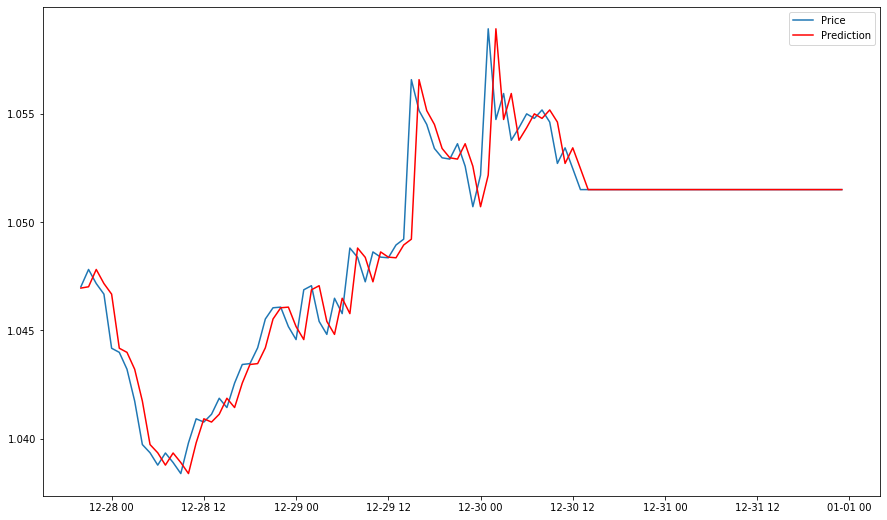

In [25]:
predictions = series.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series[int(len(series) * 0.7)+1:], predictions.iloc[int(len(series) * 0.7):]))
print('Test RMSE: %.5f' % test_score)
plt.plot(series.iloc[-100:], label='Price')
plt.plot(predictions[-100:], color='red', label='Prediction')
plt.legend()
plt.show()

**Define a function to plot `predicted vs the actual weekly percentage change`.**

In [26]:
def plot_observed_vs_predict(series, predictions):
    fig, ax = plt.subplots()
    ax = sns.regplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
                predictions.iloc[-int(len(series) * 0.3):].pct_change(), )
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title('EURUSD Observed vs Predicted Values')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='#888888')
    ax.axvline(x=0, color='#888888')
    sns.despine(ax=ax, offset=0)
    plt.xlim(-0.05, 0.05)
    plt.ylim(-0.05, 0.05)
    return plt.show()

**Plot `predicted vs the actual weekly percentage change` and Calculate Mean Absolute Error (MAE)**

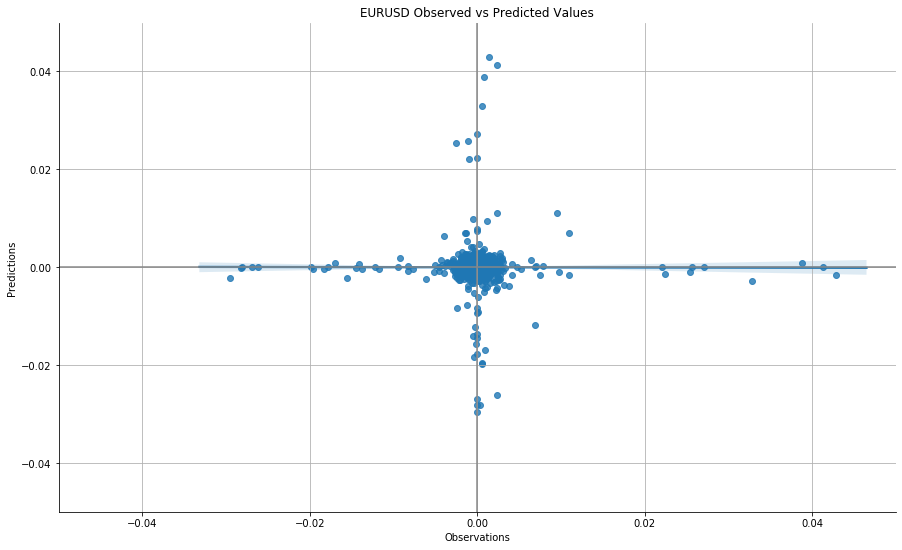

The MAE is 0.0012


In [27]:
plot_observed_vs_predict(series, predictions)

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - predictions.iloc[-int(len(series) * 0.3):].pct_change()).mean(),4)
print(f'The MAE is {mae}')

**(!) No trend, predictions are not correlated with observations.**

In [28]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), predictions.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 61.12%


**(!) Predictions were correct in 61% of cases.**

**Use the AR class from statmodels**=linear regression model.
- split the series into a “training” and “testing” dataset and create an empty list which we are going to use to store our predictions. This is because this time we are going to make our weekly predictions one by one, in a “walk-forward” manner.
- generate a 1 period-forward prediction, 
- append that value to our predictions list to store it, 
- extract the value from the test data whose index corresponds to the current value of our for-loop iterator and append that value to the end of our training data.

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test MSE: 0.00296


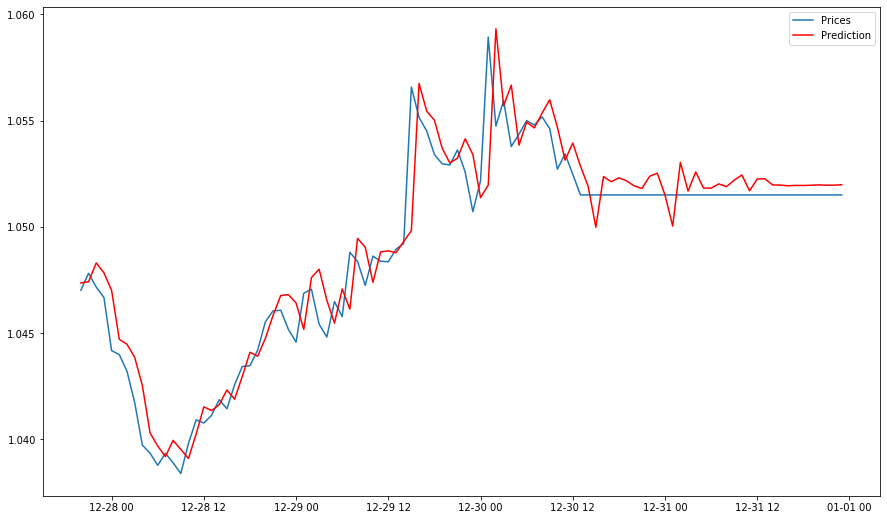

In [29]:
historic = series.iloc[:int(len(series) * 0.7)].to_list()
test = series.iloc[int(len(series) * 0.7):]

predictions = []

for i in range(len(test)):

    model = AR(historic)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test[i])
    
predictions = pd.Series(predictions, index=test.index)
    
test_score = np.sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.5f' % test_score)
# plot results
plt.plot(test.iloc[-100:], label='Prices')
plt.plot(predictions.iloc[-100:], color='red', label='Prediction')
plt.legend()
plt.show()

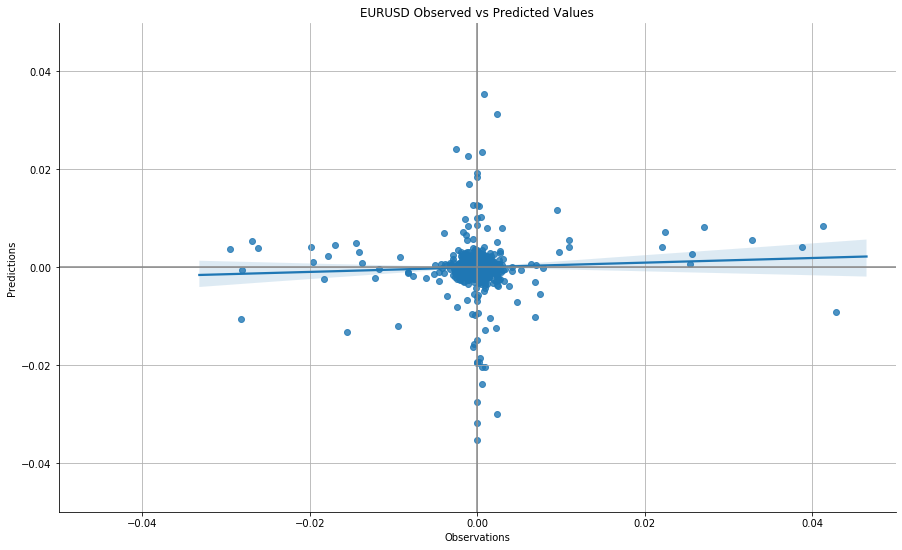

The MAE is 0.0013123302


In [30]:
plot_observed_vs_predict(series, predictions)
mae = round(abs(test.pct_change() - predictions.pct_change()).mean(),10)
print(f'The MAE is {mae}')

In [31]:
price_pred = pd.concat([test.pct_change(), predictions.pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 35.29%


**(!) The prediction with `AR` is even worse, probably, because of the last part with constant price, where `AR` predicted fluctuations.**

**Decompose the series with Hodrick-Prescott Filter and store each component.**

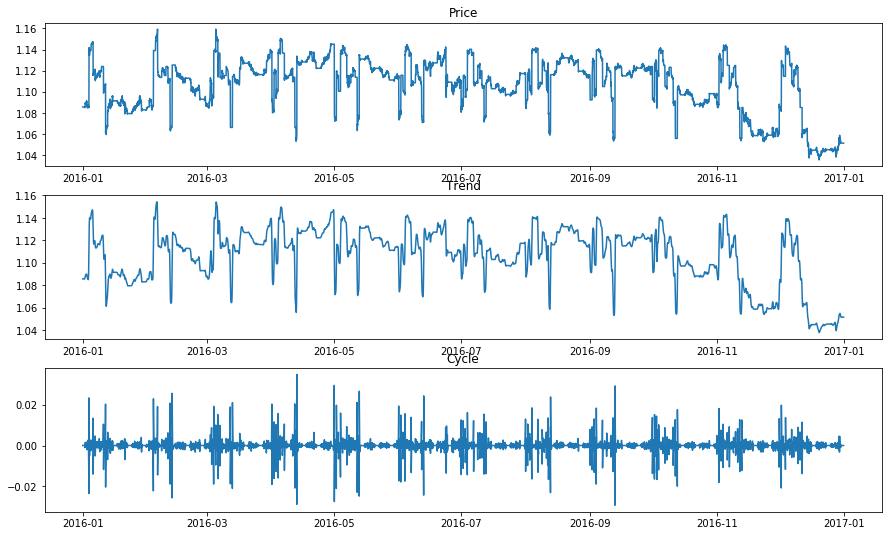

In [32]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

**Run the `AR` model with decomposed series as inputs.**

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for trend MSE: 3.474869623254728e-05


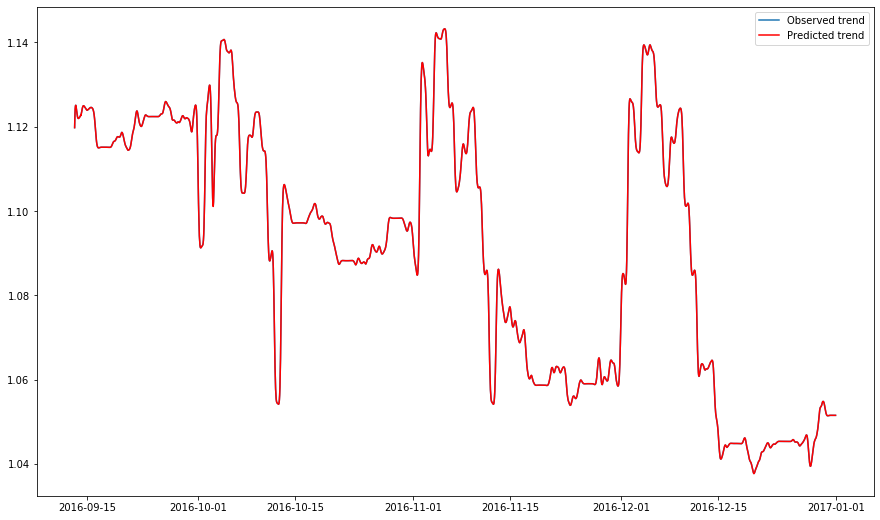

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for cycle MSE: 0.0018984922029856648


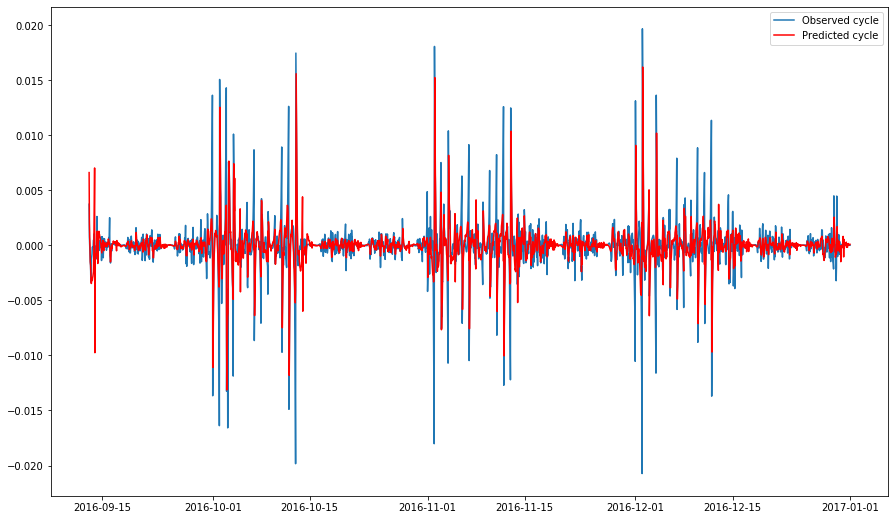

In [33]:
component_dict = {'cycle': cycle, 'trend': trend}

prediction_results = []

for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]

    predictions = []

    for i in range(len(test)):

        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

**(!) The predictions look very good!**

- **“Recompose” our data in an additive manner and**
- **calculate the RMSE when comparing the resulting combined prediction performance against the observed values.**

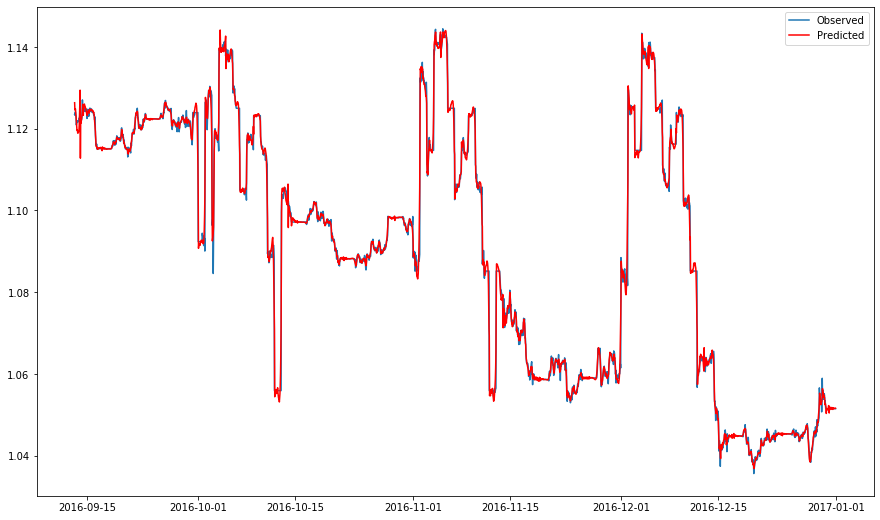

RMSE: 0.0018928487016429461


In [34]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()

test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

In [35]:
series[(8784-2636):]

Local time
2016-09-13 04:00:00    1.12346
2016-09-13 05:00:00    1.12328
2016-09-13 06:00:00    1.12402
2016-09-13 07:00:00    1.12411
2016-09-13 08:00:00    1.12349
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Freq: H, Name: Close, Length: 2636, dtype: float64

In [36]:
recomposed_preds

Local time
2016-09-13 04:00:00    1.126336
2016-09-13 05:00:00    1.124574
2016-09-13 06:00:00    1.124870
2016-09-13 07:00:00    1.124817
2016-09-13 08:00:00    1.123557
                         ...   
2016-12-31 19:00:00    1.051546
2016-12-31 20:00:00    1.051562
2016-12-31 21:00:00    1.051530
2016-12-31 22:00:00    1.051548
2016-12-31 23:00:00    1.051597
Freq: H, Name: recomposed_preds, Length: 2636, dtype: float64

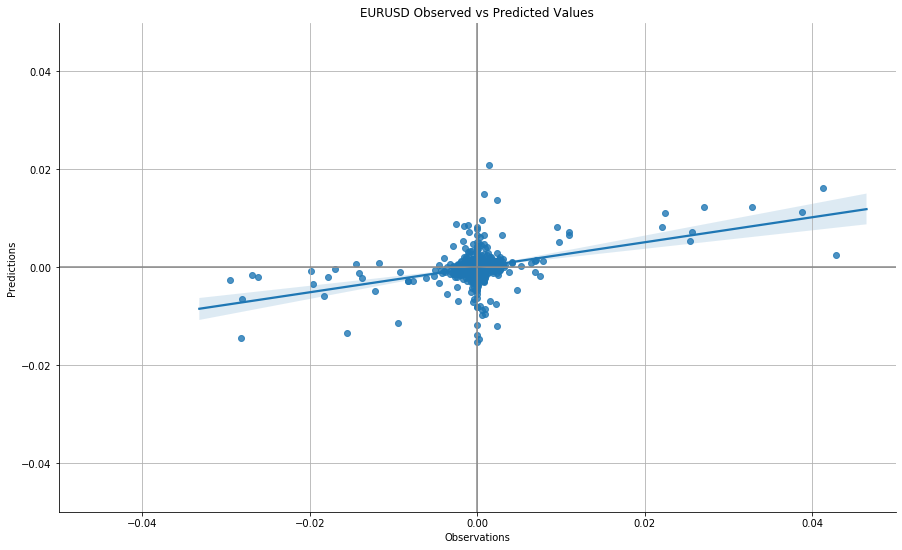

The MAE is 0.0009449788


In [37]:
plot_observed_vs_predict(series, recomposed_preds)

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

**(!) There is a positive correlation!** The prediction correlates with the observations!

In [38]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)

price_pred['hit'] = np.where(np.sign(price_pred['Close']) == np.sign(price_pred['recomposed_preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 42.67%


**(!) The hit rate is less than 50%, but the prediction interval is larger.**

**(!) `HP filter` method. The decomposition algorithm makes use of observations that come both before and after the current estimate. This injects an element of `“look-forward” bias` into our analysis, causing our recomposed predictions to be `misleadingly accurate`.**

**Let’s return now to the `STL` Decomposition.**

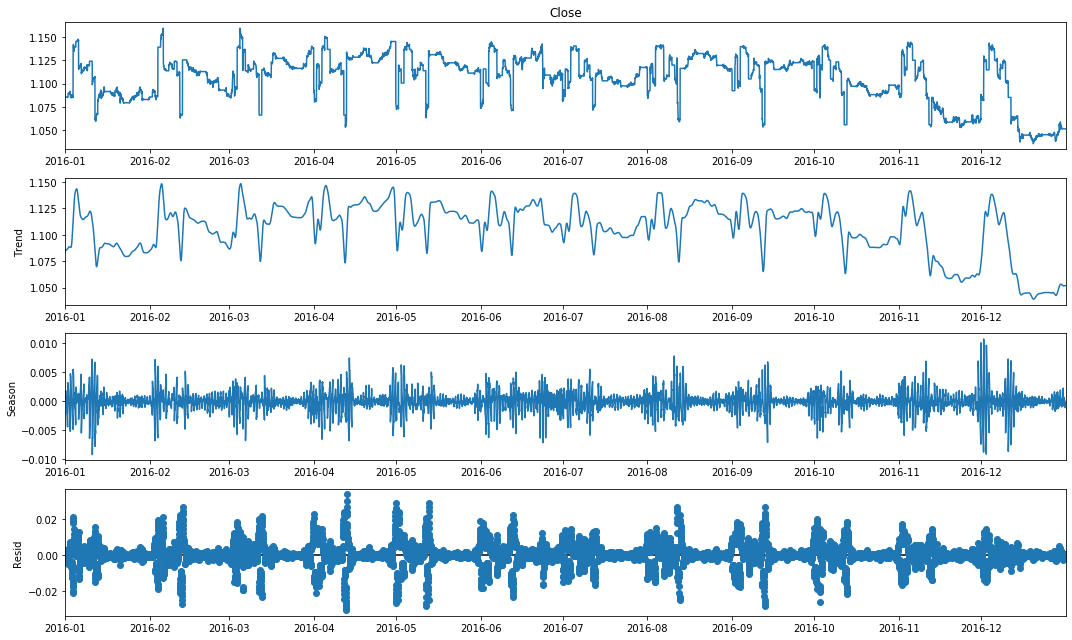

In [39]:
result = STL(series).fit()
result.plot()
plt.show()

In [40]:
result.seasonal.head()

Local time
2016-01-01 00:00:00    0.000592
2016-01-01 01:00:00    0.000596
2016-01-01 02:00:00    0.000792
2016-01-01 03:00:00    0.000962
2016-01-01 04:00:00    0.001437
Freq: H, Name: season, dtype: float64

**Run our `AR model` in the same fashion as before.**

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for seasonal MSE: 0.0005741115412008452


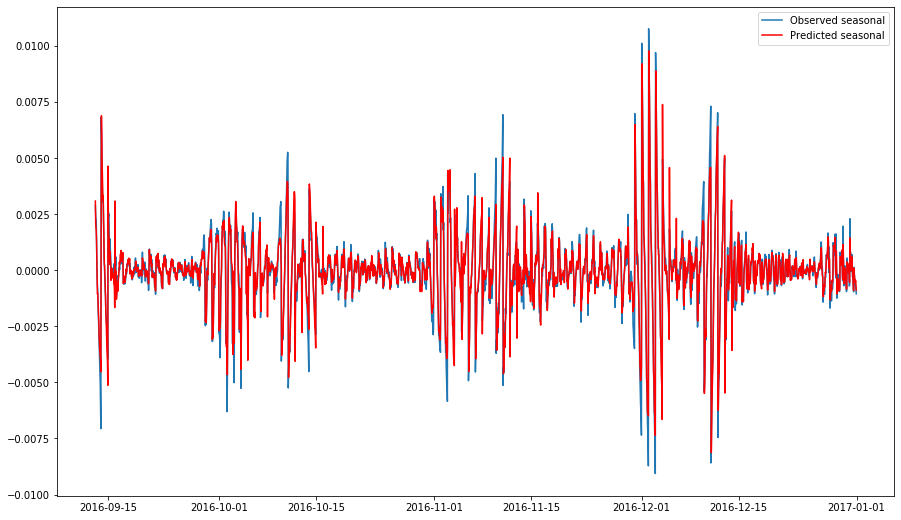

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for trend MSE: 3.741479514579071e-06


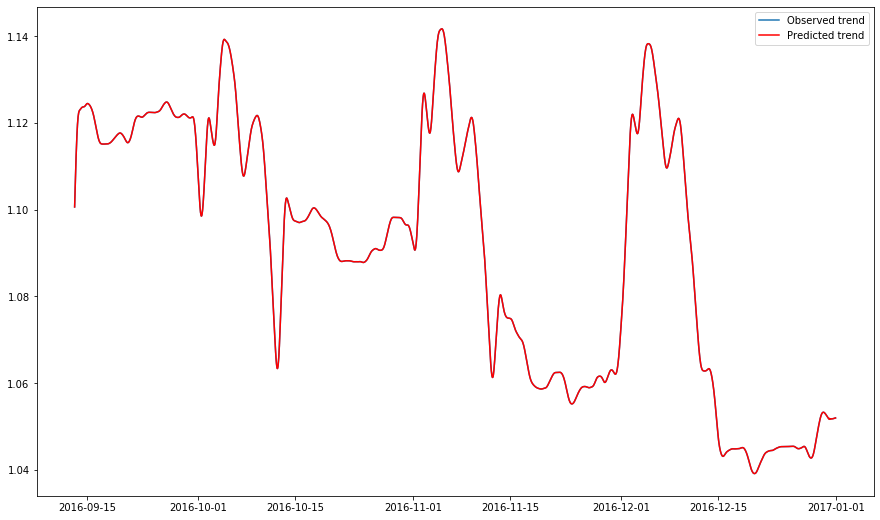

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for residual MSE: 0.001976165141816102


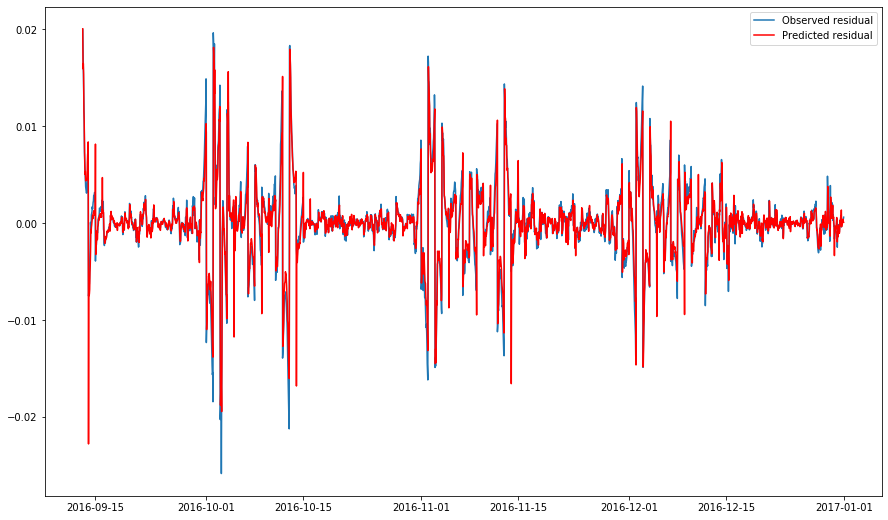

In [41]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}

prediction_results = []

for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    test = component_dict[component].iloc[int(len(series) * 0.7):]

    predictions = []

    for i in range(len(test)):

        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

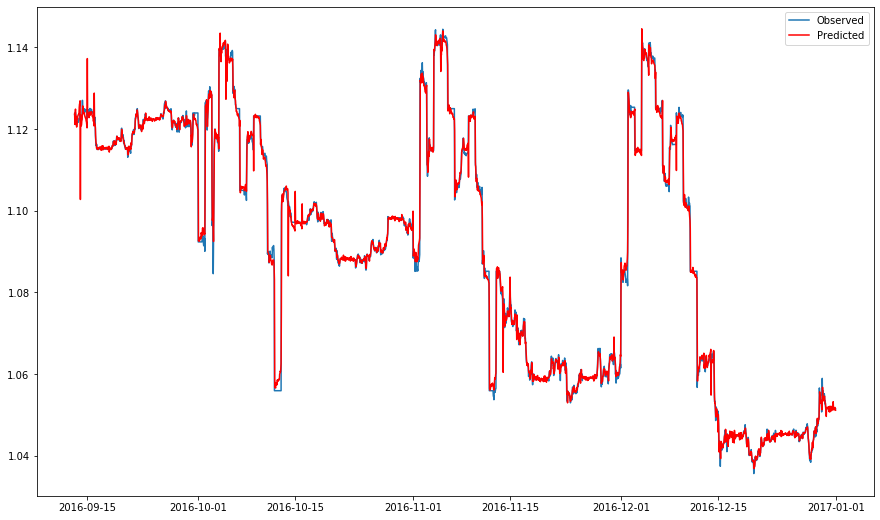

RMSE: 0.002127328623085738


In [42]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()

test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

**(!) RMSE is smaller than after HP filter.**

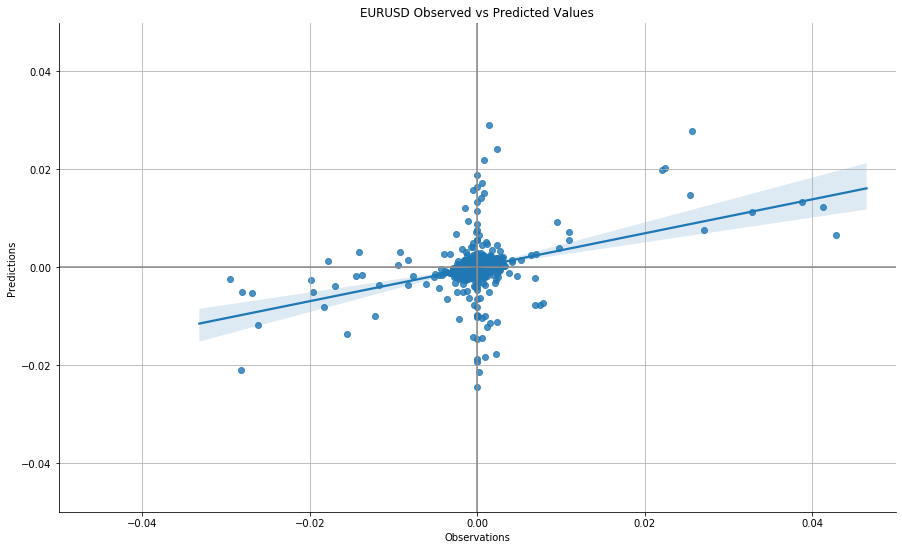

The MAE is 0.001015453


In [43]:
plot_observed_vs_predict(series, recomposed_preds)

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

**(!) The MAE is larger: 0.001015453 vs 0.0009449788.**

In [44]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 45.18%


**(!) The hit rate is larger than after HP filter!**

**(!) The `hit criterion` is the `same sign of the price change` in the prediction and in the reality.**

**(?) Why the hit rate is smaller than 50%?**

In [58]:
series[-int(len(series) * 0.3):]

Local time
2016-09-13 05:00:00    1.12328
2016-09-13 06:00:00    1.12402
2016-09-13 07:00:00    1.12411
2016-09-13 08:00:00    1.12349
2016-09-13 09:00:00    1.12290
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Freq: H, Name: Close, Length: 2635, dtype: float64

In [57]:
recomposed_preds[-int(len(series) * 0.3):]

Local time
2016-09-13 05:00:00    1.121123
2016-09-13 06:00:00    1.123806
2016-09-13 07:00:00    1.124866
2016-09-13 08:00:00    1.122901
2016-09-13 09:00:00    1.123068
                         ...   
2016-12-31 19:00:00    1.051554
2016-12-31 20:00:00    1.051689
2016-12-31 21:00:00    1.051823
2016-12-31 22:00:00    1.051395
2016-12-31 23:00:00    1.051124
Freq: H, Length: 2635, dtype: float64

In [66]:
(series[-int(len(series) * 0.3):]-recomposed_preds[-int(len(series) * 0.3):]).sum()

0.018612479166215667

In [63]:
series[-int(len(series) * 0.3):].var()

0.0009333875261886139

In [64]:
recomposed_preds[-int(len(series) * 0.3):].var()

0.0009213157370382708

In [45]:
price_pred

Price     preds  hit
Local time                                  
2016-09-13 06:00:00  0.000659  0.002393    1
2016-09-13 07:00:00  0.000080  0.000944    1
2016-09-13 08:00:00 -0.000552 -0.001747    1
2016-09-13 09:00:00 -0.000525  0.000148    0
2016-09-13 10:00:00 -0.001772 -0.001046    1
...                       ...       ...  ...
2016-12-31 19:00:00  0.000000  0.000337    0
2016-12-31 20:00:00  0.000000  0.000129    0
2016-12-31 21:00:00  0.000000  0.000127    0
2016-12-31 22:00:00  0.000000 -0.000407    0
2016-12-31 23:00:00  0.000000 -0.000258    0

[2634 rows x 3 columns]

In [51]:
price_pred['Price']-price_pred['preds']

Local time
2016-09-13 06:00:00   -0.001734
2016-09-13 07:00:00   -0.000864
2016-09-13 08:00:00    0.001195
2016-09-13 09:00:00   -0.000673
2016-09-13 10:00:00   -0.000726
                         ...   
2016-12-31 19:00:00   -0.000337
2016-12-31 20:00:00   -0.000129
2016-12-31 21:00:00   -0.000127
2016-12-31 22:00:00    0.000407
2016-12-31 23:00:00    0.000258
Freq: H, Length: 2634, dtype: float64

In [48]:
round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)

45.18

In [49]:
price_pred['hit'].sum()

1190

In [50]:
price_pred['hit'].count()

2634

In [68]:
np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']))#, 1, 0)

(array([   0,    1,    2, ..., 2596, 2598, 2599]),)

**Run AR just on the last 100 points**

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for seasonal MSE: 0.0002719836156615992


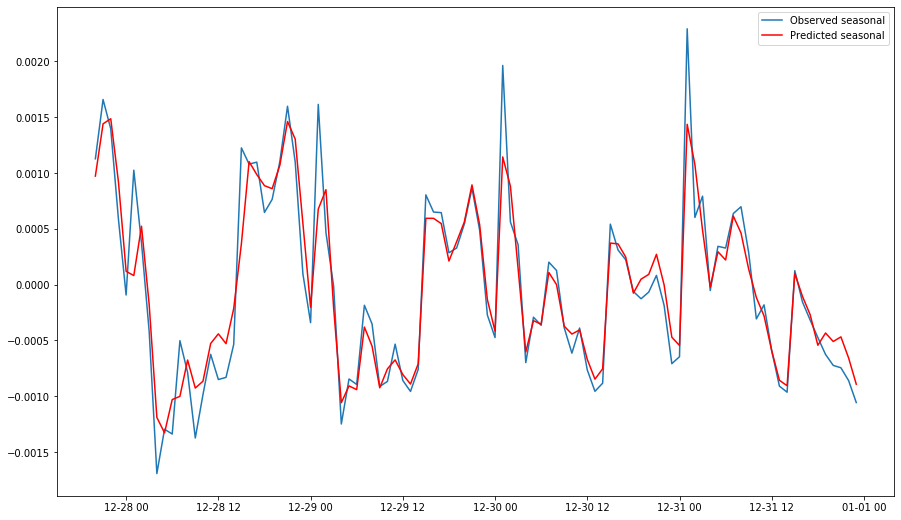

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for trend MSE: 1.8821395920146316e-05


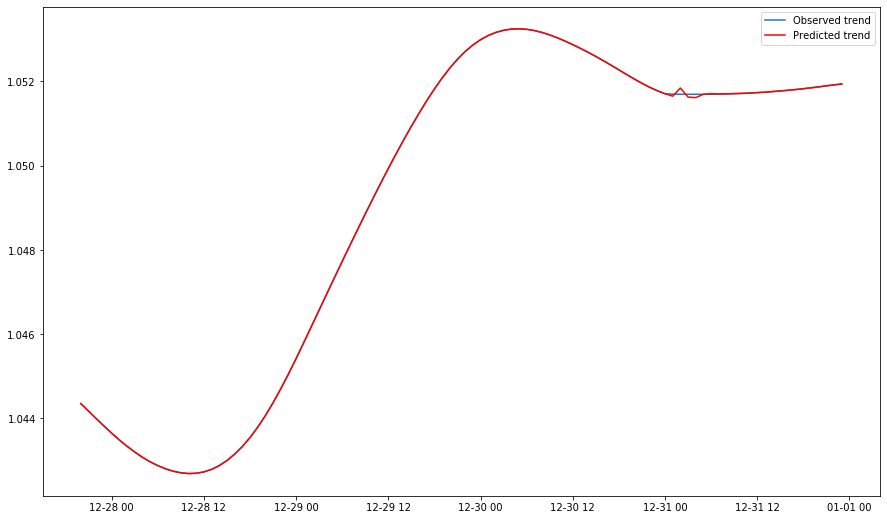

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning:


statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)




Test for residual MSE: 0.0009005208762809915


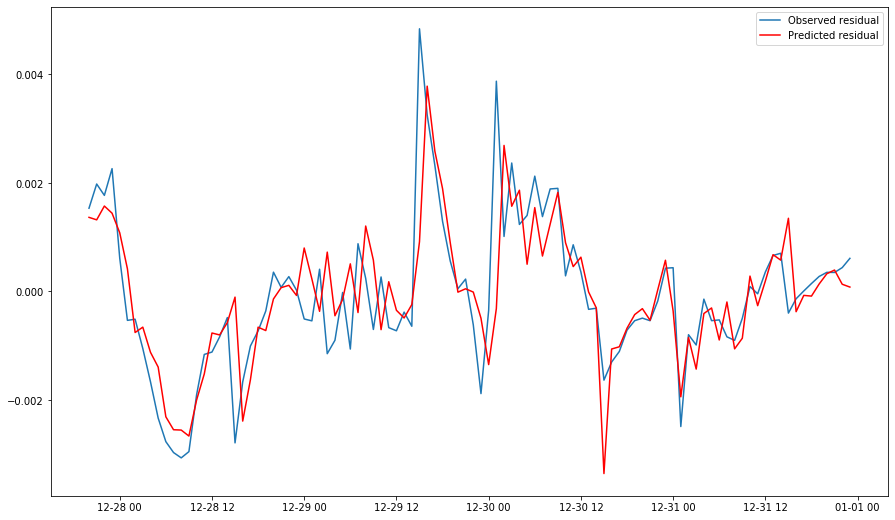

In [69]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}

prediction_results = []

for component in ['seasonal', 'trend', 'residual']:
    #historic = component_dict[component].iloc[:int(len(series) * 0.7)].to_list()
    #test = component_dict[component].iloc[int(len(series) * 0.7):]
    historic = component_dict[component].iloc[:len(series)-100].to_list()
    test = component_dict[component].iloc[len(series)-100:]


    predictions = []

    for i in range(len(test)):

        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

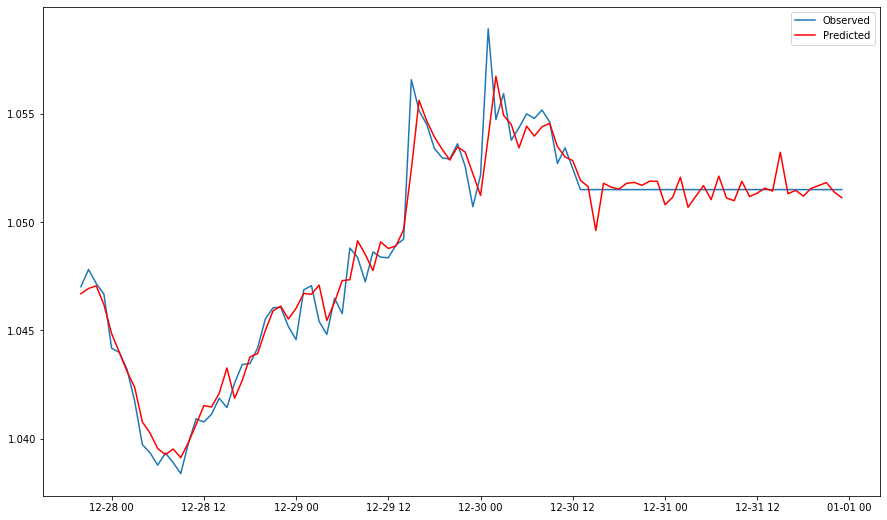

RMSE: 0.0009558854321746441


In [71]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
#plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(series.iloc[len(series)-100:], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()

test_score = np.sqrt(mean_squared_error(series.iloc[len(series)-100:], recomposed_preds))
print(f'RMSE: {test_score}')

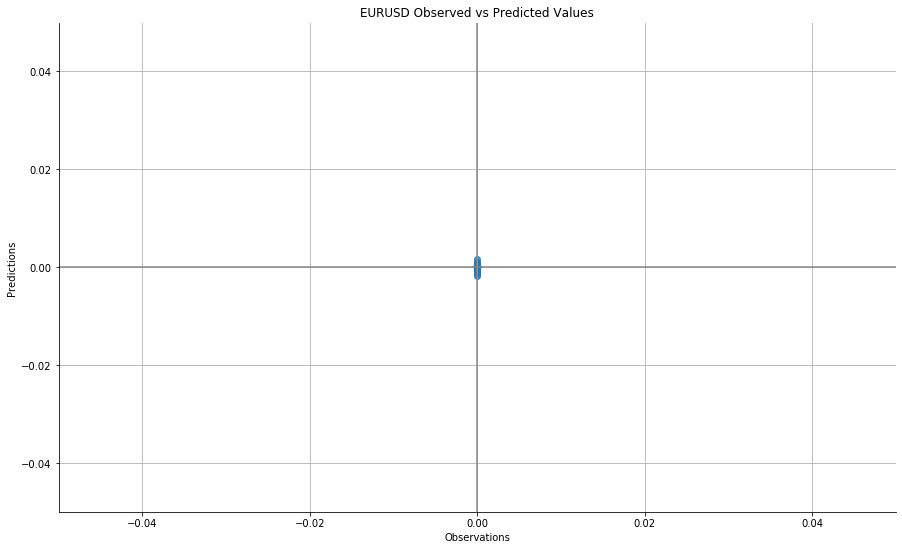

The MAE is 0.0008896166


In [76]:
plot_observed_vs_predict(series[-100:], recomposed_preds[-100:])

#mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
#                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
mae = round(abs(series.iloc[-100:].pct_change() - 
                recomposed_preds.iloc[-100:].pct_change()).mean(),10)
print(f'The MAE is {mae}')

In [77]:
#price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred = pd.concat([series.iloc[-100:].pct_change(), recomposed_preds.iloc[-100:].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 44.44%


**(!) The hit rate is even worse!** Probably, due to the last part, where there were no change, but the model was giving some fluctuations.

## Use auto_arima <a id='auto_arima'></a>
We use [auto_arima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima) from [pmdarima](https://pypi.org/project/pmdarima/) from [pypi.org](https://pypi.org), see [tips and tricks](http://alkaline-ml.com/pmdarima/tips_and_tricks.html) for the explanation of parameters.

In [30]:
!pip install pmdarima

In [31]:
#!pip install joblib

In [27]:
# from pmdarima import auto_arima  # deprecated
import pmdarima as pm

/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [28]:
# Make a default fit
model = pm.auto_arima(df_close, seasonal=True, m=1) # max_D=2 and m=732 is too slow
model.summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8783
Model:               SARIMAX(0, 1, 0)   Log Likelihood               36700.830
Date:                Thu, 25 Mar 2021   AIC                         -73397.661
Time:                        19:47:03   BIC                         -73383.500
Sample:                             0   HQIC                        -73392.836
                               - 8783                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.891e-06   4.07e-05     -0.096      0.924   -8.36e-05    7.58e-05
sigma2      1.373e-05   2.57e-08    534.265      0.000    1.37e-05    1.38e-05
===================================================================================
Ljung-Box (Q):                      681.61   Jarque-Bera (JB):           6738079.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             2.75
Prob(H) (two-sided):                  0.00   Kurtosis:                       138.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**(?) Why the resulting model is SARIMAX(0,1,0) and not (0,1,0)(0,1,0) ?**

**(?) Is it because of `m=1`?**

**Quickstart [Example](https://pypi.org/project/pmdarima/)**.

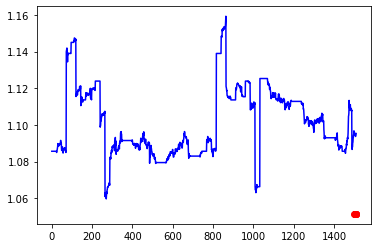

In [62]:
#import pmdarima as pm
#from pmdarima.model_selection import train_test_split  # Not working
from sklearn.model_selection import train_test_split
#import numpy as np
#import matplotlib.pyplot as plt

# Load/split your data
#y = pm.datasets.load_wineind()
y = df_close
#train, test = train_test_split(y, train_size=1500)
train, test = y[:1500], y[1500:1500+10]

# Fit your model
#model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
#x = np.arange(y.shape[0])
x = np.arange(len(train)+len(test))
#plt.plot(x[:1500], train, c='blue')
plt.plot(x,y[:1500+10], c='blue')
plt.plot(x[1500:], forecasts, 'ro')# c='green','o')
plt.show()

**(!) The fit was bad and ARIMA is NOT working.** 

In [50]:
print(test.shape[0],
      len(test),
      len(train),
      len(x))

2 2 7283 7285


## **Fast Bayesian estimation of SARIMAX models**<a id='BSARIMAX'></a>
see the [example](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_pymc3.html) from statmodels.org.

**0. Install necessary packages.**

In [57]:
# Install theano, see https://anaconda.org/conda-forge/theano
!conda install -c conda-forge theano --y

Solving environment: done

# All requested packages already installed.



In [77]:
# Install pymc3, see https://anaconda.org/conda-forge/pymc3
#!conda install -c conda-forge pymc3 --y

In [78]:
# Install pandas-datareader, see https://anaconda.org/anaconda/pandas-datareader
#!conda install -c anaconda pandas-datareader --y

**1. Import external dependencies**

In [63]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
#import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [64]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(df_close, order=(3, 1, 0))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                 8783
Model:               SARIMAX(3, 1, 0)   Log Likelihood               47475.961
Date:                Thu, 18 Feb 2021   AIC                         -94943.923
Time:                        18:00:05   BIC                         -94915.601
Sample:                             0   HQIC                        -94934.274
                               - 8783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0389      0.004      9.972      0.000       0.031       0.047
ar.L2          0.0290      0.004      6.872      0.000       0.021       0.037
ar.L3         -0.0354      0.004     -8.544      0.0

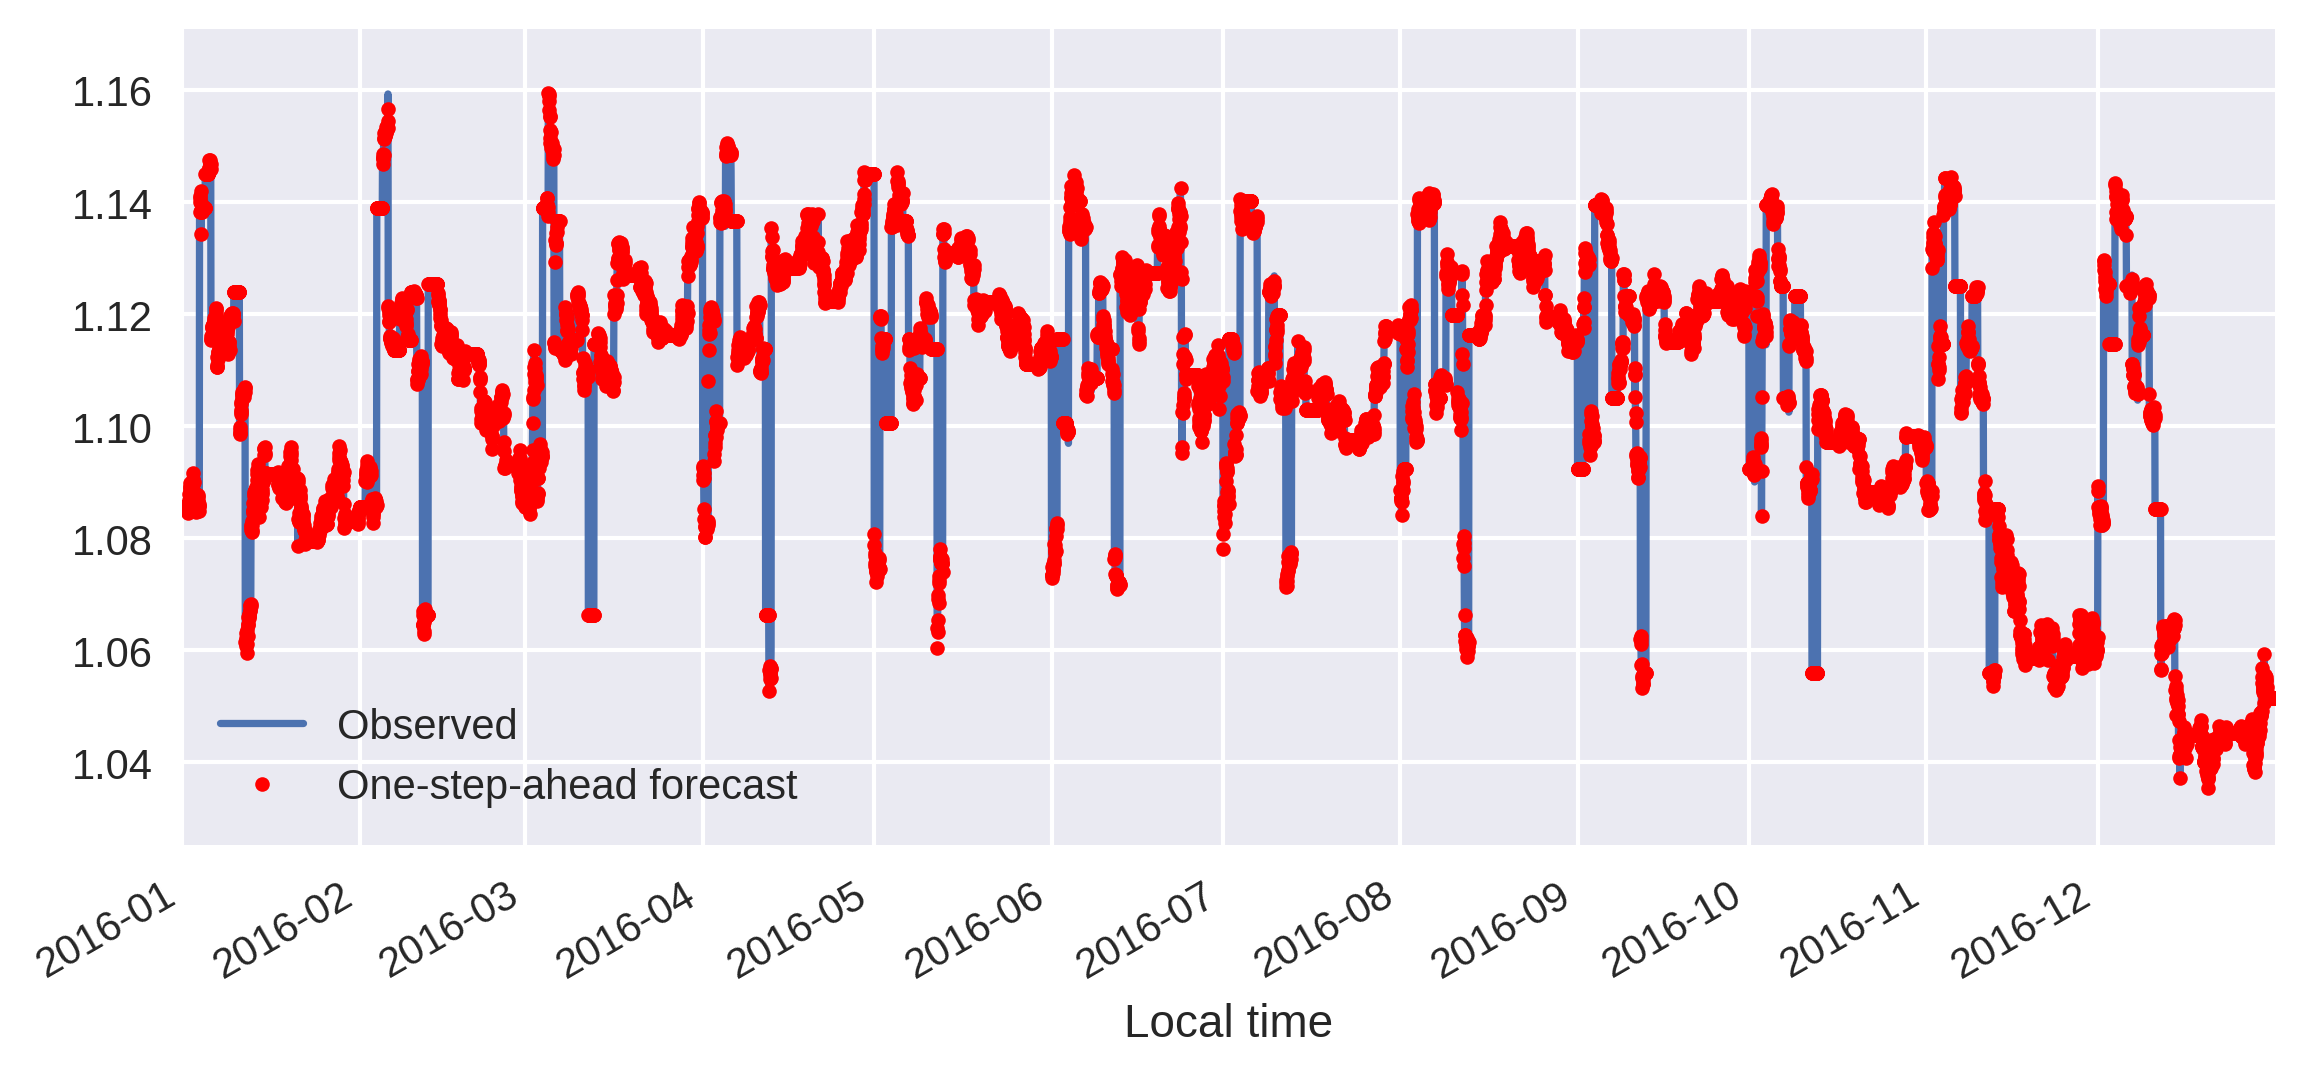

In [85]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower Close']
upper = predict_mle_ci['upper Close']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
df_close.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
#ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
ax.set_ylim([df_close.min()*0.99,df_close.max()*1.01])
plt.show()

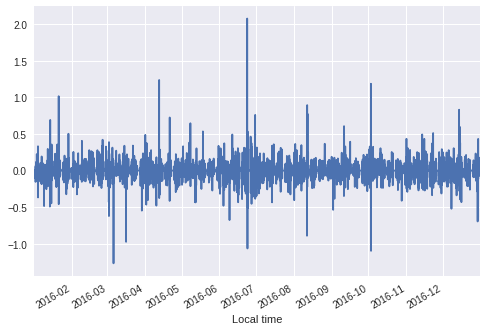

In [90]:
# Deviation of the prediction from the reality in percents
f1 = predict_mle.predicted_mean[1:]
f2 = df_close[1:]
dev = 100*(f1-f2)/f2
dev.plot();

In [91]:
# Check the sum
dev.sum()

3.503030672321171

## Check the outcome of the fits manually. <a id='ARIMAman'></a>

In [58]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

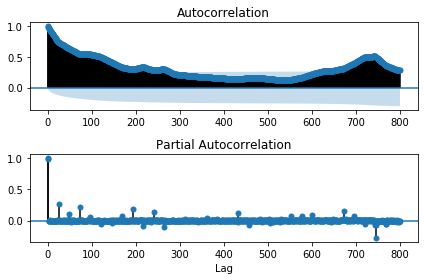

In [46]:
# Plot autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(df_close, ax=plt.gca(),lags=800)
plt.subplot(212)
plot_pacf(df_close, ax=plt.gca(),lags=800)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**(!) There is an obvious seasonality and autocorrelation!!!**

## Identify the order of differencing<a id='Order'></a>
See [ARIMA models for time series forecasting](http://people.duke.edu/~rnau/411arim2.htm) from duke.edu.
- **Rule 1:** If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
**Sutisfied**
- **Rule 2:** If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING!!
**Sutisfied**

In [36]:
def optimal_order(data,n):
    diff_std = [] 
    for i in range(n):
        diff_std.append(data.std())
        data = data.diff()
        
    return diff_std.index(min(diff_std))

In [37]:
optimal_order(df_close,100)

1

**Rule 3:** The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. **The optimal order is 1, i.e. `d=1` for our data**.

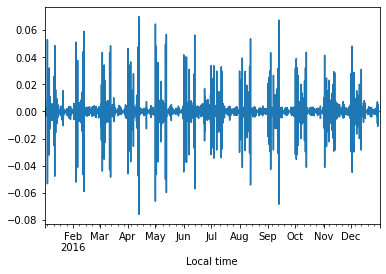

In [38]:
df_close_diff_2 = df_close_diff_1.diff()
df_close_diff_2.plot.line();

**(!) Some remaining monthly fluctuations persist also in higher orders.**

**Rule 4:** A model with no orders of differencing assumes that the original series is stationary (mean-reverting). **A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth).** A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).

**Rule 5:** A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. **In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.**

In [24]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

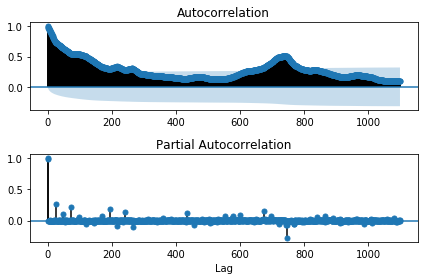

In [25]:
plt.figure()
plt.subplot(211)
plot_acf(df_close, ax=plt.gca(),lags=1.5*freq)
plt.subplot(212)
plot_pacf(df_close, ax=plt.gca(),lags=1.5*freq)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

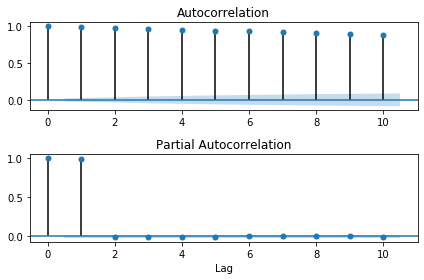

In [55]:
plt.figure()
plt.subplot(211)
plot_acf(df_close, ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(df_close, ax=plt.gca(),lags=10)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

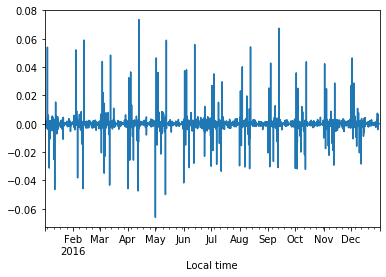

In [31]:
df_close_diff_1 = df_close.diff().dropna()
data = df_close_diff_1
data.plot.line();

In [32]:
df_close_diff_1.value_counts()

 0.00000    2544
 0.00006      34
 0.00010      33
-0.00020      30
-0.00010      30
            ... 
-0.01286       1
 0.00276       1
-0.00152       1
-0.00387       1
 0.05417       1
Name: Close, Length: 1352, dtype: int64

In [33]:
# Remove zeros, because
# otherwise ACF and PCF plots show zeros.
data = df_close_diff_1
data = data[data!=0]
data.value_counts()

 0.00006    34
 0.00010    33
-0.00010    30
-0.00020    30
 0.00001    29
            ..
 0.00425     1
-0.01877     1
-0.00223     1
 0.00358     1
 0.00737     1
Name: Close, Length: 1351, dtype: int64

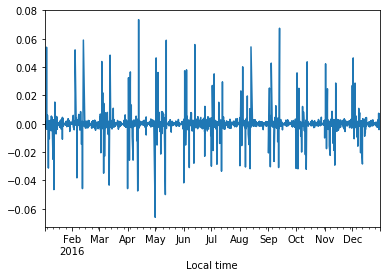

In [34]:
# Plot data without zeros, in order to see that it looks similar.
data.plot.line();

**(!) if the PACF "cuts off" at lag k--then this suggests that you should try fitting an autoregressive model of order k**

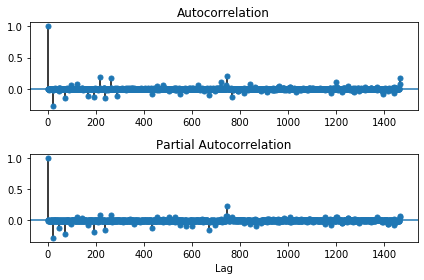

In [48]:
data = df_close_diff_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=2*freq)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=2*freq)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**(!) One differencing removed (partial)autocorrelations, so `d=1` in ARIMA.**

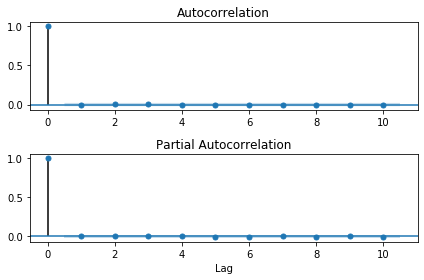

In [50]:
data = df_close_diff_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=10)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**Rule 6: The lag at which the PACF cuts off is the indicated number of AR terms, see [duke's post](http://people.duke.edu/~rnau/411arim3.htm).** 

**Rule 7: If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.**

**(!)** The non-zero partial auto correlation is only for the zero'th lag, so `k=0`, and **our model is `(0,1,0)`**.

## Check seasonality<a id='SARIMA'></a>

In [72]:
df_close_s_diff_1   = df_close.diff(freq).dropna()
df_close_s_diff_1_1 = df_close.diff(freq).diff().dropna()

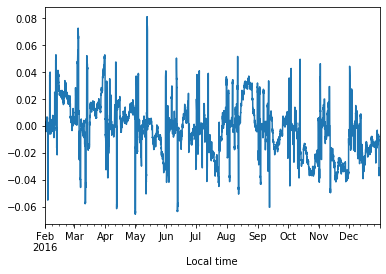

In [73]:
df_close_s_diff_1.plot.line();

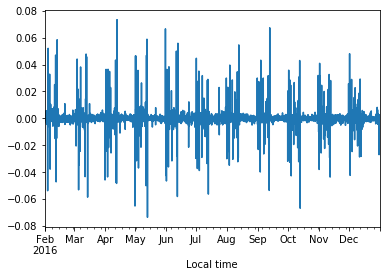

In [74]:
df_close_s_diff_1_1.plot.line();

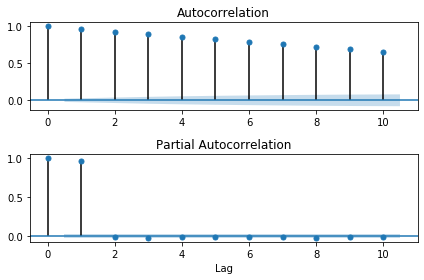

In [75]:
data = df_close_s_diff_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=10)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

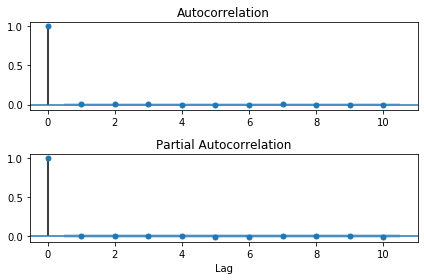

In [76]:
data = df_close_s_diff_1_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=10)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

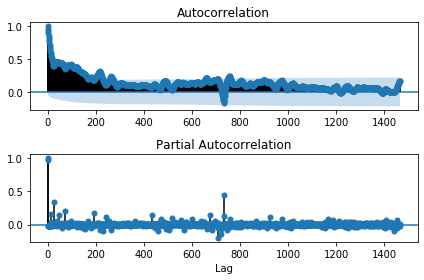

In [77]:
data = df_close_s_diff_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=2*freq)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=2*freq)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

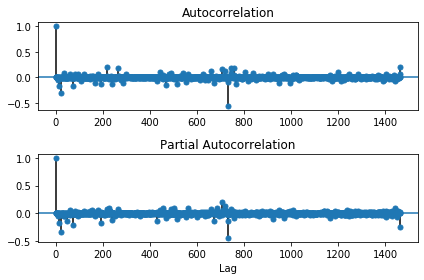

In [78]:
data = df_close_s_diff_1_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=2*freq)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=2*freq)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**(!) There is still negative correlation at `Lag=freq` !**

**Subtract seasonal component once more.**

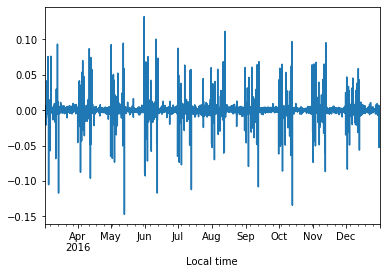

In [79]:
df_close_s_diff_2_1 = df_close_s_diff_1_1.diff(freq).dropna()
df_close_s_diff_2_1.plot.line();

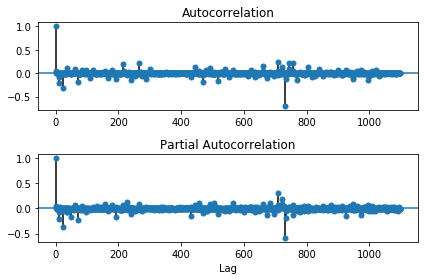

In [81]:
data = df_close_s_diff_2_1
plt.figure()
plt.subplot(211)
plot_acf(data, ax=plt.gca(),lags=1.5*freq)
plt.subplot(212)
plot_pacf(data, ax=plt.gca(),lags=1.5*freq)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**(!) There is still negative correlation at `Lag=freq` !**

## Identify the number of AR and MA terms in the ARIMA model<a id='ARMA'></a>

In [54]:
# Check without setting DatetimeIndex
auto_arima(data.Close).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8783
Model:               SARIMAX(0, 1, 0)   Log Likelihood               34498.616
Date:                Mon, 08 Mar 2021   AIC                         -68993.232
Time:                        18:19:58   BIC                         -68979.071
Sample:                             0   HQIC                        -68988.408
                               - 8783                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.887e-06   5.15e-05     -0.075      0.940      -0.000    9.71e-05
sigma2      2.267e-05   6.82e-08    332.268      0.000    2.25e-05    2.28e-05
===================================================================================
Ljung-Box (Q):                       60.80   Jarque-Bera (JB):            906215.79
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             1.19
Prob(H) (two-sided):                  0.45   Kurtosis:                        52.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**(?) The resulting model is just `I`, no `AR` no `MA`???**

**Make a stepwise fit with the parameters from [the example](https://alkaline-ml.com/pmdarima/quickstart.html#quickstart) in the pmdarima**

**(!) It is very slow, because of too many combinations. One has to choose initial parameters wisely!!!**

In [62]:
stepwise_fit = auto_arima(df_close, 
                     start_p=1, start_q=1,
                     max_p=3, max_q=3, m=12,
                     start_P=0, seasonal=True,
                     d=1, D=1, trace=True,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-67401.133, BIC=-67365.738, Fit time=25.539 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-62794.761, BIC=-62780.602, Fit time=2.275 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-65828.066, BIC=-65799.750, Fit time=16.079 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-67403.174, BIC=-67374.858, Fit time=21.199 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-66994.060, BIC=-66958.664, Fit time=35.136 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-62793.178, BIC=-62771.941, Fit time=6.921 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-67394.020, BIC=-67358.624, Fit time=55.857 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-68644.510, BIC=-68602.035, Fit time=120.444 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-67318.798, BIC=-67269.244, Fit time

KeyboardInterrupt: 

In [ ]:
stepmise_fit.summary()

**(?) The fit did not work as expected?**

#### Fit the models with neighboring parameters

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [36]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html?highlight=fit%20arima#statsmodels.tsa.arima.model.ARIMA.fit
mod = ARIMA(df_close, order=(1, 1, 0))
res = mod.fit()
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 8782
Model:                 ARIMA(1, 1, 0)   Log Likelihood               34498.966
Method:                       css-mle   S.D. of innovations              0.005
Date:                Mon, 08 Mar 2021   AIC                         -68991.931
Time:                        17:45:29   BIC                         -68970.690
Sample:                    01-01-2016   HQIC                        -68984.695
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.888e-06   5.04e-05     -0.077      0.938      -0.000    9.48e-05
ar.L1.D.Close    -0.0089      0.011     -0.836      0.403      -0.030       0.012
                                    Root

**Below we adapt the model formulated [here](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887).**

In [18]:
# Install pmdarima https://anaconda.org/saravji/pmdarima
# From jupyter notebook, sending "yes", if required
#! conda install -c saravji pmdarima --y

In [19]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
#warnings.filterwarnings("ignore")

/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


**(!) One needs to make sure that the Panda Series object has a DateTime index with inferred frequency, see [this](https://stackoverflow.com/questions/64025453/attributeerror-rangeindex-object-has-no-attribute-inferred-freq).** 

In [20]:
# Read the dataframe again, in order to be sure that nothing happened to it in previous cells.
df = pd.read_table('EURUSD_1H_2016.txt',sep=',')
df

Local time     Open     High      Low    Close  Volume
0     01.01.2016 00:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
1     01.01.2016 01:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
2     01.01.2016 02:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
3     01.01.2016 03:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
4     01.01.2016 04:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
...                       ...      ...      ...      ...      ...     ...
8778  31.12.2016 19:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8779  31.12.2016 20:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8780  31.12.2016 21:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8781  31.12.2016 22:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0
8782  31.12.2016 23:00:00.000  1.05150  1.05150  1.05150  1.05150     0.0

[8783 rows x 6 columns]

In [21]:
# Check whether Local time is of index type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null object
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


**Our indexes are just numbers => convert the column `Local time` to index, see [this](https://stackoverflow.com/questions/37610983/how-set-column-as-date-index).**

In [22]:
# Convert to datetime
df['Local time'] = pd.to_datetime(df['Local time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null datetime64[ns]
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 411.8 KB


In [23]:
# Set the index
df.set_index('Local time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 5 columns):
Open      8783 non-null float64
High      8783 non-null float64
Low       8783 non-null float64
Close     8783 non-null float64
Volume    8783 non-null float64
dtypes: float64(5)
memory usage: 411.7 KB


In [24]:
# Get "Close"
df_close = df["Close"]
df_close

Local time
2016-01-01 00:00:00    1.08564
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Name: Close, Length: 8783, dtype: float64

### Use ADF/KPSS tests, see [statmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) 

In [47]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [45]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')#, nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [48]:
adf_test(df_close)

Results of Dickey-Fuller Test:
Test Statistic                   -1.427429
p-value                           0.569058
#Lags Used                       23.000000
Number of Observations Used    8759.000000
Critical Value (1%)              -3.431097
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
dtype: float64


**(!)** Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, **the series is non-stationary**.

In [46]:
kpss_test(df_close)

Results of KPSS Test:
Test Statistic            6.827678
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [92]:
type({})

dict

**Try [adfuller](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)** test from [towardsdatascience post](https://towardsdatascience.com/monthly-spot-price-prediction-time-series-analysis-by-state-space-method-34aedf6ba294) above, see explanation of the parameter meaning [here](https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results).

In [102]:
from statsmodels.tsa.stattools import adfuller
# Constant and trend order to include in regression.
reg = ["c","ct","ctt","nc"]
for r in reg:
    res = adfuller(df_close, regression=r)
    #print(res[1])
    print('trend: {}\t p-value: {}'.format(r,res[1]))

trend: c	 p-value: 0.5690581010758805
trend: ct	 p-value: 0.5022405149063209
trend: ctt	 p-value: 0.053278087572720685
trend: nc	 p-value: 0.5443137878747791


In [97]:
!jupyternotebook --version

/usr/bin/sh: jupyternotebook: command not found


### Make a simple LSTM network<a id='LSTM'></a> (TODO)

### Combine LSTM and ARIMA<a id='LSTM+ARIMA'></a> (TODO)
- [Demand Forecasting for Platelet Usage: from Univariate Time Series to Multivariate Models](https://arxiv.org/pdf/2101.02305.pdf)

### Improve the LSTM by applying a wavelet transformation<a id='Wavelet'></a> (TODO)
- A blog about [Wavelets](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/?fbclid=IwAR2w32L-CDuMkAzF5NrmqmsWZu8NHmgW-bt8Em1124AQ58r7AMHam9MQdFU)